In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## Import the libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
from catboost import CatBoostClassifier

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

## Load a datasets from files

In [3]:
space = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
submission_set = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

## Divide data into X and y

In [4]:
X_space = space.drop(["Transported"], axis=1)
y_space = space["Transported"]

## EDA

In [5]:
X_space.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [6]:
X_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
dtypes: float64(6), object(7)
memory usage: 883.0+ KB


In [7]:
X_space.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
nl = '\n'
print(f"Missing values sum by the particular columns:{nl}{X_space.isna().sum()}")

Missing values sum by the particular columns:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64


In [9]:
print(f"Percent of missing values by particular columns:{nl}\
{np.around(X_space.isna().sum()/X_space.shape[0] * 100,2)}")

Percent of missing values by particular columns:
PassengerId     0.00
HomePlanet      2.31
CryoSleep       2.50
Cabin           2.29
Destination     2.09
Age             2.06
VIP             2.34
RoomService     2.08
FoodCourt       2.11
ShoppingMall    2.39
Spa             2.11
VRDeck          2.16
Name            2.30
dtype: float64


In [10]:
print(f"Number of unique values: {nl}{X_space.nunique()}")

Number of unique values: 
PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
dtype: int64


### Check a correlation between variables

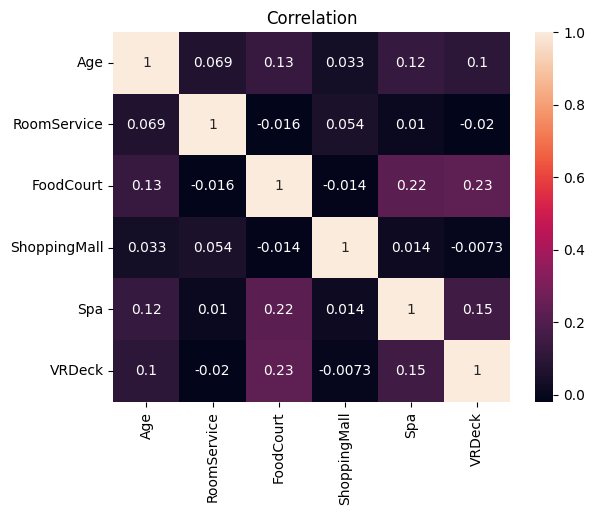

In [11]:
num_vars = X_space.select_dtypes(include="float64")
correlation = num_vars.corr()
plt.title("Correlation")
sns.heatmap(correlation, annot=True)
plt.show()

### Distribution of target variable

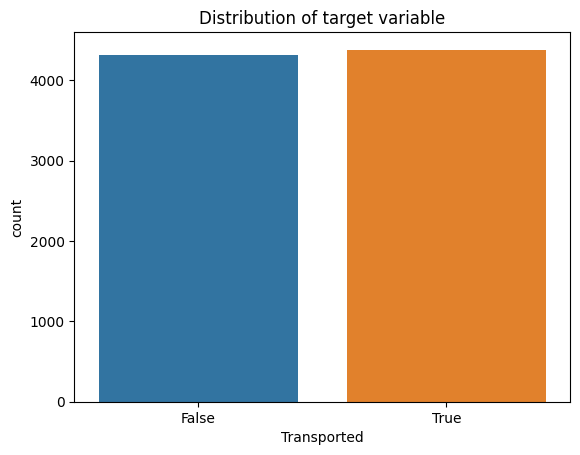

In [12]:
sns.countplot(space, x="Transported")
plt.title("Distribution of target variable")
plt.show()

### Distribution of Homeplanet

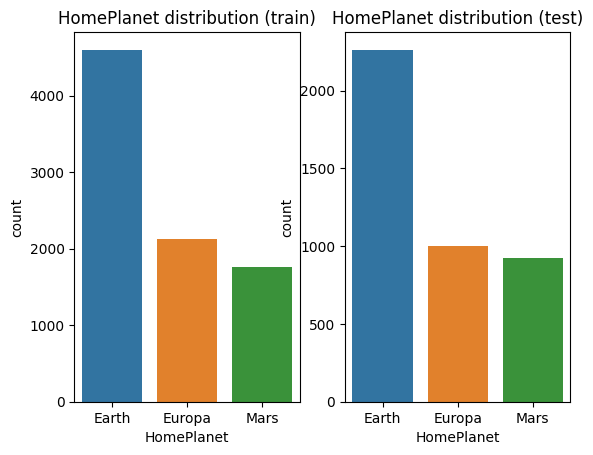

In [13]:
fig, ax =plt.subplots(1,2)
sns.countplot(X_space, x="HomePlanet", ax=ax[0], order = X_space['HomePlanet'].value_counts().index)
ax[0].set(title='HomePlanet distribution (train)')
sns.countplot(submission_set, x="HomePlanet", ax=ax[1])
ax[1].set(title='HomePlanet distribution (test)')
fig.show()

### Distribution of deck and side

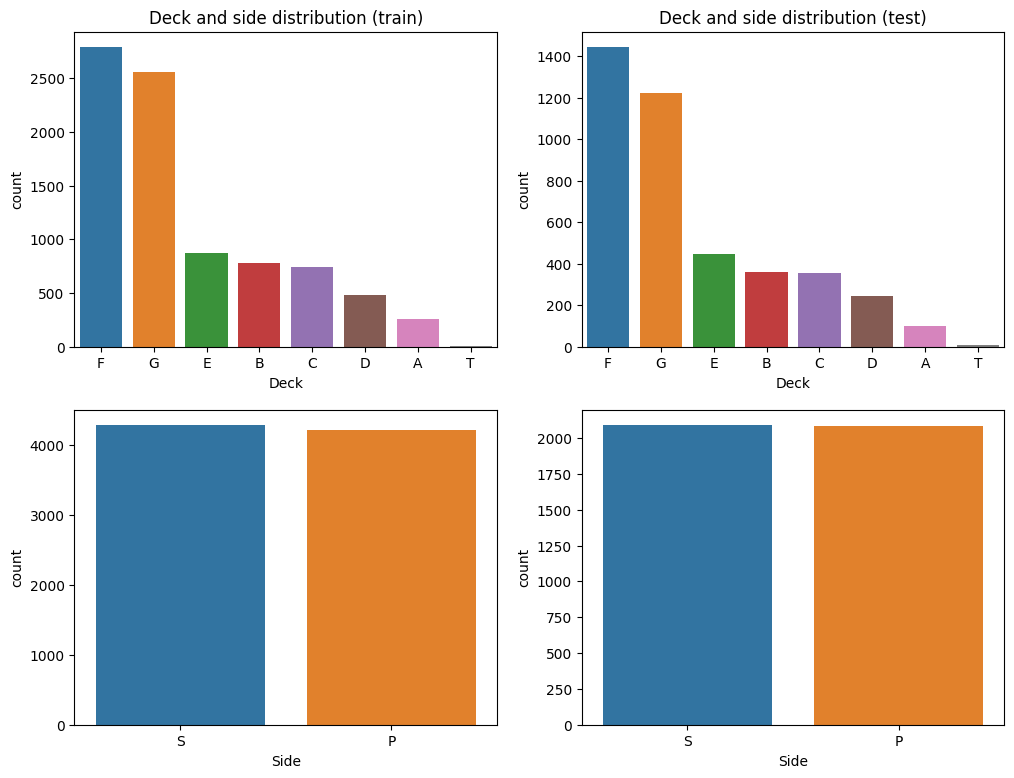

In [14]:
def deck_side(df):
    df[["Deck", "Side"]] = df.Cabin.str.split("/", expand=True).loc[:, [0, 2]]
    df = df.drop(["Cabin"], axis=1)
    return df
df_train = deck_side(X_space)
df_test = deck_side(submission_set)
fig, ax =plt.subplots(2,2, figsize=(12,9))
sns.countplot(df_train, x="Deck", ax=ax[0,0], order = df_train['Deck'].value_counts().index)
ax[0,0].set(title="Deck and side distribution (train)")
sns.countplot(df_test, x="Deck", ax=ax[0,1], order = df_test['Deck'].value_counts().index)
ax[0,1].set(title="Deck and side distribution (test)")
sns.countplot(df_train, x="Side", ax=ax[1,0], order = df_train['Side'].value_counts().index)
sns.countplot(df_test, x="Side", ax=ax[1,1], order = df_test['Side'].value_counts().index)
fig.show()

## Feature engineering

### Remove unnecessary columns

In [15]:
def drop_columns(df):    
    df = df.drop(["PassengerId", "Name"], axis=1)
    return df

In [16]:
drop_columns(X_space)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,P
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,S
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,S
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,S


### Add new features

In [17]:
def feature_eng(df):
    df[["Deck", "Side"]] = df.Cabin.str.split("/", expand=True).loc[:, [0, 2]]
    df = df.drop(["Cabin"], axis=1)
    df["Expenses"] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]\
    .sum(axis=1)
    return df

In [18]:
feature_eng(X_space)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Side,Expenses
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,P,0.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,S,736.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,S,10383.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,S,5176.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,S,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,A,P,8536.0
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,G,S,0.0
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,G,S,1873.0
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,E,S,4637.0


## Creating a pipeline

### Add data type selector

In [19]:
cat_col_sel = make_column_selector(dtype_exclude=np.float64)
num_col_sel = make_column_selector(dtype_include=np.float64)

### Impute and encode categorical data

In [20]:
cat_imp = SimpleImputer(strategy="most_frequent")
cat_ohe = OneHotEncoder(handle_unknown="ignore")

cat_pipeline = make_pipeline(cat_imp, cat_ohe)
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

### Impute and scale numeric data

In [21]:
num_imp = SimpleImputer(strategy="median")
num_scaler = StandardScaler()

num_pipeline = make_pipeline(num_imp, num_scaler)
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### Join numeric and categorical columns

In [22]:
col_trans = make_column_transformer(
    (num_pipeline, num_col_sel),
    (cat_pipeline, cat_col_sel)
)

col_trans

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7d1993213bb0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7d19c3fb9810>)])

### Create a function pipeline to preprocessing

In [23]:
rmv_cols = FunctionTransformer(drop_columns)
feat_cols = FunctionTransformer(feature_eng)

### Join all components to one preprocess pipeline

In [24]:
preprocess = make_pipeline(rmv_cols, feat_cols, col_trans)
preprocess

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function drop_columns at 0x7d19817eb6d0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function feature_eng at 0x7d19817e81f0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d1993213bb0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d19c3fb9810>)]))])

## Divide data into train and validation sets

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_space, y_space, test_size=0.15,
                                                      random_state=42)

In [26]:
print(f"Train set shape: {nl}{X_train.shape}")

Train set shape: 
(7389, 15)


In [27]:
print(f"Validation set shape: {nl}{X_valid.shape}")

Validation set shape: 
(1304, 15)


## Voting classifier

### Model training

In [28]:
clf1 = DecisionTreeClassifier()
clf2 = LogisticRegression()
clf3 = SVC()
eclf = VotingClassifier(estimators=[("dtc", clf1), ("lr", clf2), ("svm", clf3)])
model = make_pipeline(preprocess, eclf)

In [29]:
score = cross_val_score(model, X_train, y_train, scoring="accuracy",cv=5)

In [30]:
score

array([0.77740189, 0.79296346, 0.80311231, 0.79837618, 0.81178064])

In [31]:
_ = model.fit(X_train, y_train)

### Model testing

In [32]:
predictions = model.predict(X_valid)
print(f"F1-score: {np.around(f1_score(y_valid, predictions),2)}")

F1-score: 0.79


In [33]:
print(f"Accuracy: {np.around(accuracy_score(y_valid, predictions), 2)}")

Accuracy: 0.79


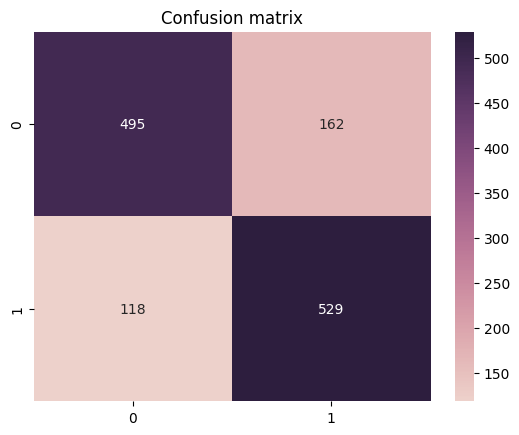

In [34]:
conf_mat = confusion_matrix(y_valid, predictions)
plt.title("Confusion matrix")
sns.heatmap(conf_mat, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='d')
plt.show()

### Hyperparameter tuning

In [35]:
params = {"dtc__max_depth": [2, 5, 10],
    "dtc__min_samples_leaf": [5, 10, 20],
    "lr__penalty" : ["l2", "l1", "elasticnet"],
    "lr__solver" : ["lbfgs", "newton-cholesky"],
    "svm__kernel" : ["poly", "rbf"],
    "svm__C" : [0.5, 1.0]}
clf1 = SVC()
clf2 = DecisionTreeClassifier()
clf3 = LogisticRegression()
eclf1 = VotingClassifier(estimators=[("svm", clf1), ("dtc", clf2), ("lr", clf3)])

In [36]:
X_train_preprocess = preprocess.fit_transform(X_train)
gridcv = GridSearchCV(eclf1,param_grid=params, cv=3)

In [37]:
gridcv.fit(X_train_preprocess, y_train)

GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('svm', SVC()),
                                                    ('dtc',
                                                     DecisionTreeClassifier()),
                                                    ('lr',
                                                     LogisticRegression())]),
             param_grid={'dtc__max_depth': [2, 5, 10],
                         'dtc__min_samples_leaf': [5, 10, 20],
                         'lr__penalty': ['l2', 'l1', 'elasticnet'],
                         'lr__solver': ['lbfgs', 'newton-cholesky'],
                         'svm__C': [0.5, 1.0], 'svm__kernel': ['poly', 'rbf']})

In [38]:
gridcv.best_params_

{'dtc__max_depth': 10,
 'dtc__min_samples_leaf': 5,
 'lr__penalty': 'l2',
 'lr__solver': 'lbfgs',
 'svm__C': 1.0,
 'svm__kernel': 'poly'}

### Testing model after hyperparameter tunig

In [39]:
X_valid_preprocess = preprocess.transform(X_valid)
gridcv.best_estimator_.score(X_valid_preprocess, y_valid)

0.7875766871165644

In [40]:
y_pred = gridcv.predict(X_valid_preprocess)
print(f"F1-score: {np.around(f1_score(y_valid, y_pred),2)}")

F1-score: 0.79


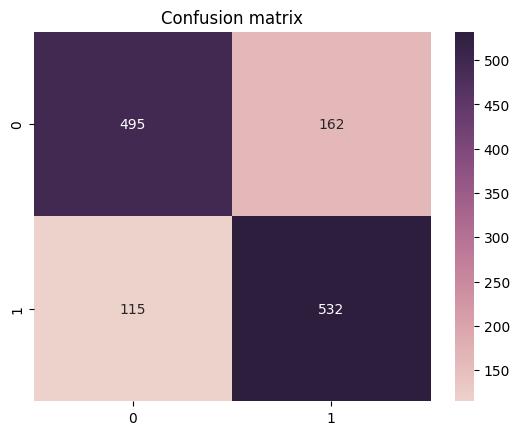

In [41]:
conf_mat = confusion_matrix(y_valid, y_pred)
plt.title("Confusion matrix")
sns.heatmap(conf_mat, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='d')
plt.show()

## XGboost

### Model training

In [42]:
xgclf = XGBClassifier()
model1 = make_pipeline(preprocess, xgclf)
model1

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function drop_columns at 0x7d19817eb6d0>)),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=<function feature_eng at 0x7d19817e81f0>)),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='m...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [43]:
score = cross_val_score(model1, X_train, y_train, scoring="accuracy",cv=5)
score

array([0.77604871, 0.79364005, 0.80987821, 0.80987821, 0.80907244])

In [44]:
_ = model1.fit(X_train, y_train)

### Model testing

In [45]:
X_valid_preprocess = preprocess.transform(X_valid)
np.around(model1.score(X_valid, y_valid), 2)

0.79

In [46]:
y_pred = model1.predict(X_valid)
print(f"F1-score: {np.around(f1_score(y_valid, y_pred),2)}")

F1-score: 0.79


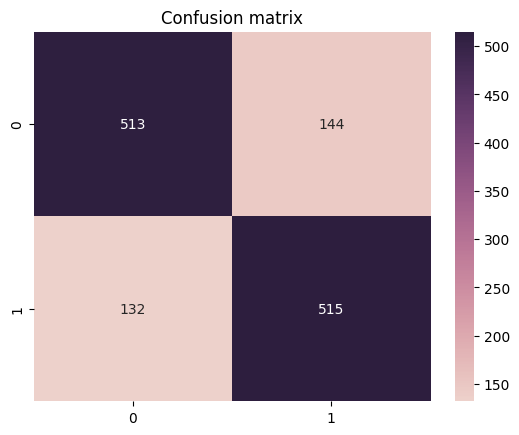

In [47]:
conf_mat = confusion_matrix(y_valid, y_pred)
plt.title("Confusion matrix")
sns.heatmap(conf_mat, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='d')
plt.show()

### Hyperparameter tuning

In [48]:
params = { 
    "max_depth":[3, 5,10],
    "n_estimators": [100, 200, 300 , 400],
    "min_samples_leaf": [5, 10, 20],
    "eta":[0.1, 0.2, 0.3]
}
xgboost1 = XGBClassifier(verbosity = 0)

In [49]:
X_train_preprocess = preprocess.fit_transform(X_train)
xgboost_gridcv = GridSearchCV(xgboost1,param_grid=params, cv=4)

In [50]:
xgboost_gridcv.fit(X_train_preprocess, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.1, 0.2, 0.3], 'max_depth': [3, 5, 10],
                         'min_samples_leaf': [5, 10, 20],
                         'n_estimators': [100, 200, 300, 400]})

In [51]:
xgboost_gridcv.best_params_

{'eta': 0.1, 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}

### Model testing

In [52]:
np.around(xgboost_gridcv.best_estimator_.score(X_valid_preprocess, y_valid), 2)

0.8

In [53]:
y_pred =xgboost_gridcv.predict(X_valid_preprocess)
print(f"F1-score: {np.around(f1_score(y_valid, y_pred),2)}")

F1-score: 0.8


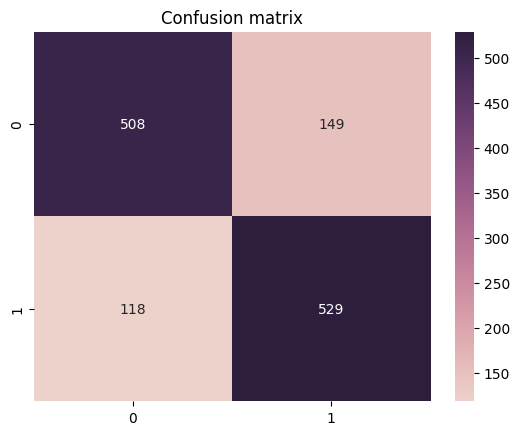

In [54]:
conf_mat = confusion_matrix(y_valid, y_pred)
plt.title("Confusion matrix")
sns.heatmap(conf_mat, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='d')
plt.show()

## Make a submisson

In [55]:
submission_set_preprocess = preprocess.transform(submission_set)
final_predictions = xgboost_gridcv.predict(submission_set_preprocess)

In [56]:
preds = final_predictions.astype("bool")
preds

array([ True, False,  True, ...,  True,  True,  True])

In [57]:
submission_df = pd.DataFrame({"PassengerId": submission_set["PassengerId"], "Transported": preds})
submission_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [58]:
submission_df.to_csv("submission.csv", index=False)